In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json
from utils.random import simulate_ANNRDM_individual
from utils.utils import get_parameters_range, hdi
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["pdf.use14corefonts"] = True

In [8]:
root = "../"
plots_root = "Results/individual/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 

dataset_path = datasets_root + "AI Models Results/fastText_FC.csv"
stan_file_path = root +  "models/stan/ANN-RDM/individual/drifts_recovery.stan" 

In [13]:
number_of_participants = 2
n_trials = 200

In [14]:
# set sampling parameters
n_iter = 2000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

threshold_priors = [2, 1]          # For all models with RDM
ndt_priors = [0, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5]                # For models wtih non-decision time modulation
drift_priors = [1, 2]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1]              # For models with drift mapping functions
b_priors = [0, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

def get_stan_parameters(generated_df):
    N = len(generated_df)                                                    # For all models
    p = generated_df.loc[:, ["word_prob", "non_word_prob"]].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
    frequency = generated_df["zipf"].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
    frequencyCondition = generated_df["category"].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
    response = generated_df["response"].to_numpy().astype(int)               # for all models
    rt = generated_df["rt"].to_numpy()                                       # for all models
    minRT = generated_df["minRT"].to_numpy()                                 # for all models
    RTbound = 0.1                                                             # for all models
    ndt = generated_df["ndt"]

    # define input for the model
    data_dict = {"N": N,
                 "response": response,
                 "rt": rt,
                 "minRT": minRT,
                 "RTbound": RTbound,
                 "frequency": frequency,
                 "frequencyCondition": frequencyCondition,
                 "threshold_priors": threshold_priors,
                 "ndt_priors": ndt_priors,
                 "g_priors": g_priors,
                 "m_priors": m_priors,
                 "drift_priors": drift_priors,
                 "p": p,
                 "alpha_priors": alpha_priors,
                 "b_priors": b_priors,
                 "k_priors": k_priors,
                 "ndt":ndt
                 }
    return data_dict

In [15]:
def save_results_to_csv(fit, parameters_set):
    columns = {"mean_alpha":-1, "mean_b":-1, "mean_k_1":-1, 
               "mean_k_2":-1,"mean_g":-1, "mean_m":-1,
               "mean_threshold_word":-1, "mean_threshold_nonword":-1,
               "median_alpha":-1, "median_b":-1, "median_k_1":-1, 
               "median_k_2":-1, "median_g":-1, "median_m":-1,
               "median_threshold_word":-1, "median_threshold_nonword":-1}
    
    recoverd_df = pd.DataFrame([], columns=columns.keys())
    stan_variables = fit.stan_variables()

    columns["mean_k_1"] = stan_variables["transf_k_1"].mean()
    columns["median_k_1"] = np.median(stan_variables["transf_k_1"])
    columns["real_k_1"] = parameters_set.loc["k_1", "generated"]
    columns["HDI_k_1_bottom"], columns["HDI_k_1_top"] = hdi(stan_variables["transf_k_1"])

    columns["mean_k_2"] = stan_variables["transf_k_2"].mean()
    columns["median_k_2"] = np.median(stan_variables["transf_k_2"])
    columns["real_k_2"] = parameters_set.loc["k_2", "generated"]
    columns["HDI_k_2_bottom"], columns["HDI_k_2_top"] = hdi(stan_variables["transf_k_2"])
    
    columns["mean_alpha"] = stan_variables["transf_alpha"].mean()
    columns["median_alpha"] = np.median(stan_variables["transf_alpha"])
    columns["real_alpha"] = parameters_set.loc["alpha", "generated"]
    columns["HDI_alpha_bottom"], columns["HDI_alpha_top"] = hdi(stan_variables["transf_alpha"])

    columns["mean_b"] = stan_variables["transf_b"].mean()
    columns["median_b"] = np.median(stan_variables["transf_b"])
    columns["real_b"] = parameters_set.loc["b", "generated"]
    columns["HDI_b_bottom"], columns["HDI_b_top"] = hdi(stan_variables["transf_b"])
    
#     columns["mean_g"] = stan_variables["transf_g"].mean()
#     columns["median_g"] = np.median(stan_variables["transf_g"])
#     columns["real_g"] = parameters_set.loc["g", "generated"]
#     columns["HDI_g_bottom"], columns["HDI_g_top"] = hdi(stan_variables["transf_g"])
    
#     columns["mean_m"] = stan_variables["transf_m"].mean()
#     columns["median_m"] = np.median(stan_variables["transf_m"])
#     columns["real_m"] = parameters_set.loc["m", "generated"]
#     columns["HDI_m_bottom"], columns["HDI_m_top"] = hdi(stan_variables["transf_m"])

    columns["mean_threshold_word"] = stan_variables["transf_threshold_word"].mean()
    columns["median_threshold_word"] = np.median(stan_variables["transf_threshold_word"])
    columns["real_threshold_word"] = parameters_set.loc["threshold_word", "generated"]
    columns["HDI_threshold_word_bottom"], columns["HDI_threshold_word_top"] = hdi(stan_variables["transf_threshold_word"])
    
    columns["mean_threshold_nonword"] = stan_variables["transf_threshold_nonword"].mean()
    columns["median_threshold_nonword"] = np.median(stan_variables["transf_threshold_nonword"])
    columns["real_threshold_nonword"] = parameters_set.loc["threshold_nonword", "generated"]
    columns["HDI_threshold_nonword_bottom"], columns["HDI_threshold_nonword_top"] = hdi(stan_variables["transf_threshold_nonword"])
    
    recoverd_df = pd.concat([recoverd_df, pd.DataFrame(columns, index=[0])])

    output_path="drifts_recovery_results.csv"
    recoverd_df.to_csv(output_path,
                       mode="a",
                       header=not os.path.exists(output_path),
                       index=False)

## Simulation and Estimation process

In [16]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])

In [17]:
rdm_model = cmdstanpy.CmdStanModel(model_name="ANN-RDM_full_FC",
                                   stan_file=stan_file_path)

In [18]:
iteration_count = 0
params_range = pd.read_csv("Data/params_range.csv", index_col=0)
while iteration_count <= number_of_participants:
    print(f"Iteration for participant {iteration_count+1} Started")
    parameters_set = params_range.copy()
    parameters_set["generated"] = np.random.normal(loc=parameters_set.iloc[:, 0],
                                                   scale=parameters_set.iloc[:, 1])

    behavioral_df = simulate_ANNRDM_individual(n_trials=n_trials, trials_info_df=word_nword_df,
                                         parameters_set=parameters_set)
    stan_parameters = get_stan_parameters(behavioral_df)
    fit = rdm_model.sample(data=stan_parameters,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       show_console=False)
    
    df = fit.summary()
    badRhat = False
    for f in df["R_hat"]:
        if f >= 1.01 or f <= 0.9:
            badRhat = True
    
    if badRhat:
        print("Split R-hat values are not satisfactory for all parameters. repeating iteration") 
    else:
        save_results_to_csv(fit, parameters_set)
        iteration_count += 1
        print(f"Iteration for participant {iteration_count+1} Finished") 
    

Iteration for participant 1 Started


19:53:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:54:00 - cmdstanpy - INFO - CmdStan done processing.



Iteration for participant 2 Finished
Iteration for participant 2 Started


19:54:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:54:41 - cmdstanpy - INFO - CmdStan done processing.
19:54:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: drifts_recovery_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/drifts_recovery.stan', line 89, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Iteration for participant 3 Finished
Iteration for participant 3 Started


19:55:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

19:55:20 - cmdstanpy - INFO - CmdStan done processing.
19:55:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: drifts_recovery_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/drifts_recovery.stan', line 89, column 4 to column 36)
Exception: drifts_recovery_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'E:/Workspace/Thesis/ANN-EAM/models/stan/ANN-RDM/individual/drifts_recovery.stan', line 89, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Iteration for participant 4 Finished


## Particpants parameter recovery

In [20]:
recovery_data = pd.read_csv("drifts_recovery_results.csv", header=0)
parameters = ["k_1", "k_2", "alpha", "b", "threshold_word",  "threshold_nonword"] 

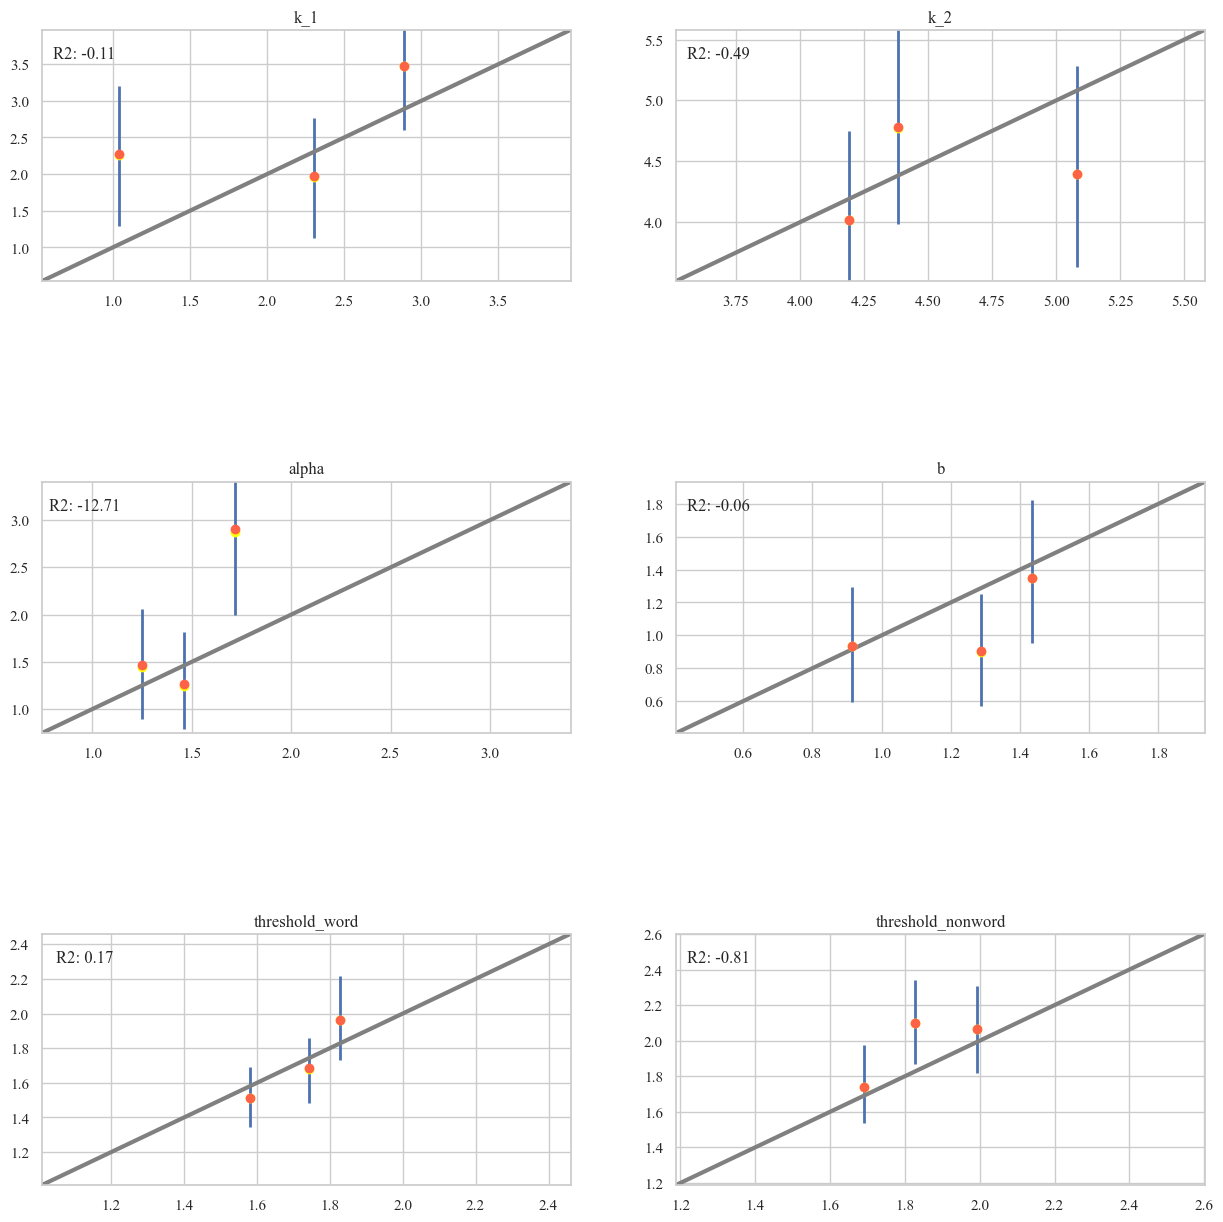

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.8)
raveled_axes = axes.ravel()

for index, parameter in enumerate(parameters):      
    posterior_mean = recovery_data["mean_"+parameter]
    posterior_median = recovery_data["median_"+parameter]
    true = recovery_data["real_"+parameter]
    raveled_axes[index].scatter(true, posterior_mean, color="tomato",
                                zorder=10)
    raveled_axes[index].scatter(true, posterior_median, color="yellow",
                                zorder=9)
    raveled_axes[index].vlines(x=true.to_numpy(), linewidth=2,
                               ymin=recovery_data["HDI_"+parameter+"_bottom"].to_numpy(),
                               ymax=recovery_data["HDI_"+parameter+"_top"].to_numpy())
    raveled_axes[index].set_title(parameter)
    min_true_point =true.min()
    max_true_point = true.max()
    recoverline = raveled_axes[index].axline(
        (min_true_point, min_true_point),
        (max_true_point, max_true_point))
    plt.setp(recoverline, linewidth=3, color="grey")
    r2 = r2_score(true, posterior_mean)
    raveled_axes[index].text(0.08, 0.9, f"R2: {r2:.2f}", horizontalalignment='center',
     verticalalignment='center', transform=raveled_axes[index].transAxes)
    
    custom_xlim = (min(min_true_point, posterior_mean.min())-0.5,  max(max_true_point, posterior_mean.max())+0.5)
    custom_ylim = (min(min_true_point, posterior_mean.min())-0.5, max(max_true_point, posterior_mean.max())+0.5)

    # Setting the values for all axes.
    plt.setp(raveled_axes[index], xlim=custom_xlim, ylim=custom_ylim)
    
plt.savefig(root + "Parameter Recovery/Plots/ANN-RDM_Full_FC_ParameterRecovery.pdf")